# Block exploring

In [2]:
from blockchain import blockexplorer as be
from datetime import datetime
import json

import requests
import requests_cache

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx

from pprint import pprint

plt.style.use('ggplot')
%matplotlib inline

In [3]:
BASE_URL = "https://blockchain.info/"
TIMEOUT = 10

T_GENESIS =1231006505000
ms_per_day = 1000*60*60*24

# Set path of file for caching API calls
requests_cache.install_cache('../bci')

## Query by block height

In [4]:
payload = None
max_height = 10000
block_list = []
multi_trans_blocks = []
for height in range(0, max_height):
    resource = 'block-height/{0}?format=json'.format(height)
    response_content = requests.get(BASE_URL + resource, payload, timeout=TIMEOUT).content
    json_response = json.loads(response_content)
    ##pprint(json_response)
    if json_response['blocks'][0]['n_tx'] > 1:
        print("Multiple transactions at height {0}".format(height))
        multi_trans_blocks.append(json_response['blocks'])
    block_list.append(json_response['blocks'])
block_list_flat = [item for sublist in block_list for item in sublist]

Multiple transactions at height 170
Multiple transactions at height 181
Multiple transactions at height 182
Multiple transactions at height 183
Multiple transactions at height 187
Multiple transactions at height 221
Multiple transactions at height 248
Multiple transactions at height 496
Multiple transactions at height 524
Multiple transactions at height 545
Multiple transactions at height 546
Multiple transactions at height 586
Multiple transactions at height 593
Multiple transactions at height 707
Multiple transactions at height 728
Multiple transactions at height 943
Multiple transactions at height 1055
Multiple transactions at height 1056
Multiple transactions at height 1184
Multiple transactions at height 1213
Multiple transactions at height 1296
Multiple transactions at height 1389
Multiple transactions at height 1454
Multiple transactions at height 1586
Multiple transactions at height 1767
Multiple transactions at height 1945
Multiple transactions at height 1967
Multiple transact

## Parse the transactions in the blocks

In [6]:
tx_in_list = []
tx_out_list = []
tx_in_dfs = []
tx_out_dfs = []
mts = [181, 182, 183]
#for block in [block_list_flat[multi] for multi in mts]:
for block in block_list_flat:
    height = block['height']
    
    for i_tx in range(block['n_tx']):
        tx_hash = block['tx'][i_tx]['hash']
        for in_dict in block['tx'][i_tx]['inputs']:

            if 'prev_out' in in_dict.keys():
                prev_out_dict = {}
                for key, val in in_dict['prev_out'].items():
                    prev_out_dict['prev_' + key] = val
                prev_out_dict = {**{'height': height, 'tx_hash': tx_hash}, **prev_out_dict}
                tx_in_list.append(prev_out_dict)
                    
            else:
                tx_in_dict = {**{'height': height, 'tx_hash': tx_hash}, **in_dict}
                tx_in_list.append(tx_in_dict)
                
            
        for out_dict in block['tx'][i_tx]['out']:
            tx_out_dicts = {**{'height': height, 'tx_hash': tx_hash}, **out_dict}
            tx_out_list.append(tx_out_dicts)
tx_in_df = pd.DataFrame(tx_in_list)
tx_out_df = pd.DataFrame(tx_out_list)

In [37]:
all_transactions = pd.merge(tx_out_df, tx_in_df, on = 'tx_hash', how = 'outer')
#                            left_on = ['addr', 'tx_index'], 
#                            right_on = ['prev_addr', 'prev_tx_index'])
transactions = all_transactions.loc[pd.notnull(all_transactions['prev_addr']), :]
mining_transactions = all_transactions.loc[pd.notnull(all_transactions['script_y']), :]
all_transactions.head(10)

,addr,addr_tag,addr_tag_link,height_x,n,script_x,spent,tx_hash,tx_index,type,...,prev_addr,prev_n,prev_script,prev_spent,prev_tx_index,prev_type,prev_value,script_y,sequence,witness
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,Genesis of Bitcoin,https://en.bitcoin.it/wiki/Genesis_block,0,0,4104678afdb0fe5548271967f1a67130b7105cd6a828e0...,False,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,14849,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0104455468652054696d65732030332f4a61...,4.294967e+09,
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,NaN,NaN,1,0,410496b538e853519c726a2c91e61ec11600ae1390813a...,False,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,14854,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0104,4.294967e+09,
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,NaN,NaN,2,0,41047211a824f55b505228e4c3d5194c1fcfaa15a456ab...,False,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,14855,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d010b,4.294967e+09,
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,NaN,NaN,3,0,410494b9d3e76c5b1629ecf97fff95d7a4bbdac87cc260...,False,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,14856,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d010e,4.294967e+09,
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,NaN,NaN,4,0,4104184f32b212815c6e522e66686324030ff7e5bf08ef...,False,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,14857,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d011a,4.294967e+09,
5,1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu,NaN,NaN,5,0,410456579536d150fbce94ee62b47db2ca43af0a730a04...,False,63522845d294ee9b0188ae5cac91bf389a0c3723f084ca...,14858,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0120,4.294967e+09,
6,1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a,NaN,NaN,6,0,410408ce279174b34c077c7b2043e3f3d45a588b85ef4c...,False,20251a76e64e920e58291a30d4b212939aae976baca40e...,14859,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0123,4.294967e+09,
7,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM,NaN,NaN,7,0,4104a59e64c774923d003fae7491b2a7f75d6b7aa3f356...,False,8aa673bc752f2851fd645d6a0a92917e967083007d9c16...,14860,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d012b,4.294967e+09,
8,1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj,NaN,NaN,8,0,4104cc8d85f5e7933cb18f13b97d165e1189c1fb3e9c98...,False,a6f7f1c0dad0f2eb6b13c4f33de664b1b0e9f22efad599...,14861,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d012c,4.294967e+09,
9,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S,NaN,NaN,9,0,410411db93e1dcdb8a016b49840f8c53bc1eb68a382e97...,True,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,14862,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0134,4.294967e+09,


In [26]:
transactions['addr'].value_counts().head(10)

12higDjoCCNXSA95xZMWUdPvXNmkAduhWv    335
198aMn6ZYAczwrE5NvNTUMyJ5qkfy4g3Hi    110
1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm     20
17afxUJouat3fkaaQ9tZrDThxdkXGL4WrM     20
1P2ZAuW9nUrFfwgVjfL2SA9sPXSruCfzp8     16
15oUEZFKAC8E8BTLt1s1jx4fPxumwB3ecr     10
1PxeCXMZBuXHt4CqWWEQ7Kwgdyob9P955L     10
1JSxDnLYD4XKTQ73N7in2M9XRovw5LANiu     10
1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv      8
1FBgZPF9ceV7JFDgvWzwJdPjdn6VFJqc5s      8
Name: addr, dtype: int64

In [29]:
mining_transactions['addr'].value_counts().head(10)

1JNqMB6iAwhQE3XY7N1cCtqU6swZ5H7uqB    1
135uQWV3vn5JNgQrWcLd6gWr9S2ybj2BB7    1
14fJAnsZct2PG9CcB4CsmTZMDaxKKxegLC    1
13kzDU2JtyTZKkFXxRA4WSQaKA3woDbnbE    1
1FNVpwCfuWs9sAaUv86w2rebTXJo1ipJrQ    1
13fVWiioCvhyCSQM1i8stpjYc998DestjM    1
1653LMj31vqQ2DGHj4dmNS6gge9Hx63sNG    1
12SYpKqqR8Eayo4A77yqiAF7hkQ4SCaXmk    1
1LxV6wnhbc8GwhZTwwiHvgPxkAjuBZ5N4T    1
1JYWWUaCC14szcMwAC6bd1LFjqewna3Hat    1
Name: addr, dtype: int64

In [46]:
# Keep only a few columns for graph analyses
cols = {('addr', 'addr_to'),
       ('prev_addr', 'addr_from'),
        ('height_y', 'height'),
       ('spent', 'spent_flag'),
       ('value', 'value')}

trans4graph = transactions[[c for c, _ in cols]].rename(columns = dict(cols))
#    .rename(dict(cols))
mining4graph = mining_transactions[[c for c, _ in cols]].rename(columns = dict(cols))

In [49]:
# Fill in "mining" as address from for mining transactions
mining4graph['addr_from'] = 'mining'
mining4graph.head()

,spent_flag,addr_from,addr_to,height,value
0,False,mining,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,0,5000000000
1,False,mining,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,1,5000000000
2,False,mining,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,2,5000000000
3,False,mining,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,3,5000000000
4,False,mining,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,4,5000000000


In [98]:
# Recombine
all_trans4graph = pd.concat([trans4graph, mining4graph], axis=0).sort_values('height')
all_trans4graph.head(13)

,spent_flag,addr_from,addr_to,height,value
0,False,mining,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,0,5000000000
1,False,mining,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,1,5000000000
2,False,mining,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,2,5000000000
3,False,mining,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,3,5000000000
4,False,mining,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,4,5000000000
5,False,mining,1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu,5,5000000000
6,False,mining,1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a,6,5000000000
7,False,mining,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM,7,5000000000
8,False,mining,1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj,8,5000000000
9,True,mining,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S,9,5000000000


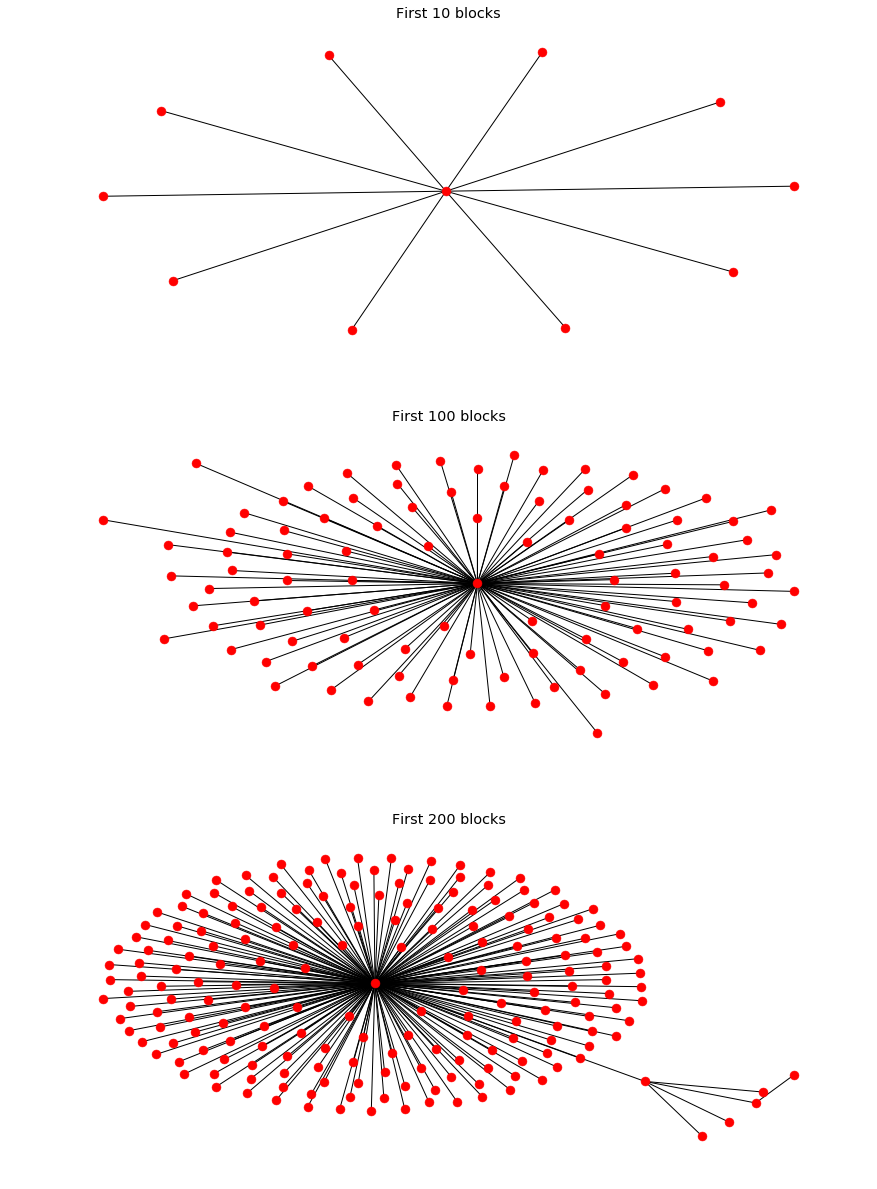

In [196]:
n_blocks = [10, 100, 200]
fig, ax_arr = plt.subplots(len(n_blocks),figsize=(15, len(n_blocks)*7))
for i in range(len(n_blocks)):
    btc_graph = nx.from_pandas_dataframe(all_trans4graph.iloc[:n_blocks[i]], 'addr_from', 'addr_to', 
                                     edge_attr = ['height', 'value','spent_flag'])
    nx.draw_networkx(btc_graph, with_labels=False, node_size = 80, ax=ax_arr[i])

    ax_arr[i].set(title='First {0} blocks'.format(n_blocks[i]))
    ax_arr[i].set_axis_off()


In [ ]:
n_blocks = 171
btc_graph = nx.from_pandas_dataframe(all_trans4graph.iloc[:n_blocks], 'addr_from', 'addr_to', 
                                     edge_attr = ['height', 'value','spent_flag'])

## Problem
At which block height appears the first non-mining transaction?

In [1]:
non_mining_max_degree = 1

height=0
while non_mining_max_degree == 1:
    height += 1
    graph2height = nx.from_pandas_dataframe(all_trans4graph.iloc[:height], 'addr_from', 'addr_to', 
                                         edge_attr = ['height', 'value','spent_flag'])
    degrees = pd.Series(graph2height.degree()).sort_values(ascending=False)
    non_mining_max_degree = degrees[1]
    
        #print(non_mining_max_degree)

print(height)

NameError: name 'nx' is not defined

In [222]:
graph2height = nx.from_pandas_dataframe(all_trans4graph.iloc[:3], 'addr_from', 'addr_to', 
                                         edge_attr = ['height', 'value','spent_flag'])
degrees = pd.Series(graph2height.degree()).sort_values(ascending=False)
degrees

mining                                3
1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1    1
1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa    1
12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX    1
dtype: int64

## Construct graph iteratively

In [205]:
G = nx.Graph()
# Add graph nodes
G.add_nodes_from(all_trans4graph['addr_to'])
G.add_nodes_from(all_trans4graph['addr_from'])
# Add directed edges and weights

10054


10055

## Query by day

In [ ]:
# x = T_GENESIS + 6*ms_per_day
# base_url = BASE_URL
# resource = 'blocks/{0}?format=json'
# resource = resource.format(x)
# payload = None

# #response = urlopen(base_url + resource, payload, timeout=TIMEOUT).read()
# response = requests.get(base_url + resource, data = payload)
# json_response = response.json()

In [ ]:
#json_response = json.loads(response)
#pprint(json_response)

In [ ]:
#block_df.iloc[0]['tx']

In [ ]:
#block_multitrans = pd.DataFrame(multi_trans_blocks)
#block_multitrans.iloc[0]['tx'][1]['inputs']

In [ ]:
#block_multitrans.head()

## Now do join to get one row for each in / out pair

## The Genesis Block

In [ ]:
# https://en.bitcoin.it/wiki/Genesis_block
genesis_hash = '000000000019d6689c085ae165831e934ff763ae46a2a6c172b3f1b60a8ce26f'
genesis_block = be.get_block(genesis_hash)


In [ ]:
print("The genesis block was mined {0}".format(datetime.fromtimestamp(genesis_block.time).strftime('%Y-%m-%d %H:%M:%S')))

In [ ]:
blocks_t = be.get_blocks(time =1231006505000)
len(blocks_t)

In [ ]:
i = 0
block_t = blocks_t[i]
block_t.hash

In [ ]:
be.get_tx(block_t.hash)

In [ ]:
tx = be.get_tx('d4af240386cdacab4ca666d178afc88280b620ae308ae8d2585e9ab8fc664a94')
tx

In [ ]:
tx.inputs[0].address